In [1]:
#!/usr/bin/env python
# -*- coding: latin-1 -*-
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import logging
import difflib
import Levenshtein as lev
from tqdm.notebook import tqdm
import multiprocessing
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import spatial
import re
import movies_df_helper_functions as helper_fn
import evaluation_helper_functions as eval_fn
import random
import imp
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import html
import csv
import re
#from sklearn.manifold import TSNE

from tabulate import tabulate
import decimal
from collections import Counter

imp.reload(eval_fn)
imp.reload(helper_fn)
%matplotlib inline

In [3]:
#load train data
#train_data_df = pd.read_csv('models/baseline_exp/train_data.csv')
train_data_df = pd.read_csv('../train_data/train_data.csv')
#load genres test data
genres_sample_df = pd.read_csv('../test_data/genres_sample_movies_id_list.csv')
#load all genres lists df
genres_df = pd.read_csv('../test_data/movies_by_genre.csv')
#load all sequel and mixed data for plotting
sequel_sampled_data_df = pd.read_csv('../test_data/sequel_and_sampled_titles_df.csv')

In [4]:
#load model
model = Doc2Vec.load('model')

In [5]:
def assign_genre(genre_df, movie_id):
    romantic_comedy= genre_df.romantic_comedy.values.tolist()
    drama = genre_df.drama.values.tolist()
    adventure = genre_df.adventure.values.tolist()
    crime = genre_df.crime.values.tolist()
    action = genre_df.action.values.tolist()
    
    if movie_id in romantic_comedy:
        return 'Romantic_Comedy'
    else:
        if movie_id in drama:
            return 'Drama'
        else: 
            if movie_id in adventure:
                return 'Adventure'
            else: 
                if movie_id in crime:
                    return 'Crime'
                else: 
                    if movie_id in action: return 'Action'
                    else: 
                        return 'Unkown'

In [6]:
#Clean train_data_df
#remove the square brackets saved when generating the test data.It i snot a bug. Data can't be saved without as they act as a column separator in the csv file
train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: actor.replace('[','').replace(']','').replace("'", "") )
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: director.replace('[','').replace(']','').replace("'", "") )
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: writer.replace('[','').replace(']','').replace("'", "") )
train_data_df['country'] = train_data_df.country.apply(lambda country: country.replace('[','').replace(']','').replace("'", "") )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: genre.replace('[','').replace(']','').replace("'", "") )

train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: actor.split(',') )
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: director.split(',') )
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: writer.split(',') )
train_data_df['country'] = train_data_df.country.apply(lambda country: country.split(',') )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: genre.split(',') )

In [7]:
train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: [a.strip() for a in actor])
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: [d.strip() for d in director])
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: [w.strip() for w in writer] )
train_data_df['country'] = train_data_df.country.apply(lambda country: [c.strip() for c in country] )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: [g.strip() for g in genre])


train_data_df[train_data_df['movie_id'] == 'agony_(film)'].values

array([['agony_(film)', 'agony',
        list(['anatoli_romashin', 'alisa_freindlich', 'velta_līne', 'alexei_petrenko']),
        list(['elem_klimov']), list(['semyon_lungin', 'ilya_nusinov']),
        list(['russian_soviet_federative_socialist_republic', 'soviet_union']),
        list(['political_drama', 'biographical_film', 'historical_film_q17013749']),
        "['velta_līne', 'elem_klimov', 'alexei_petrenko', 'anatoli_romashin', 'biographical_film', 'soviet_union', 'historical_film_q17013749', 'ilya_nusinov', 'semyon_lungin', 'political_drama', 'russian_soviet_federative_socialist_republic', 'alisa_freindlich']"]],
      dtype=object)

In [ ]:
train_data_df

In [8]:
#create dictionary with the movie_id and title
movies_dict= dict(zip(train_data_df.movie_id, train_data_df.title))


# Manual Validation

In [27]:
#Manual check


movie_id = 'godzilla_vs._biollante'
#movie_id = 'the_bunker_(2001_film)'

#movie_id='agony_(film)'

#movie_id = 'toy_story_4'
#movie_id = 'tsar_(film)'

movie_id= 'hook_(film)'
#movie_id="destiny_(1997_film)"
#movie_id="blade:_trinity"
#movie_id= 'harry_potter_and_the_half-blood_prince_(film)'
#movie_id= 'just_go_with_it'
#movie_id='high_school_musical_3:_senior_year'


similar_movies = model.docvecs.most_similar(movie_id, topn=10)
sim_movies_list = [sim[0] for sim in similar_movies]

sim_df= pd.DataFrame(columns=['Title','Similarity Ratio'])

for sim in similar_movies:
    #title = helper_fn.find_movie_title_by_id(sim[0], train_data_df)
    data = {'Title':  [sim[0]],'Similarity Ratio': [sim[1]]}
    tmp_df = pd.DataFrame(data, columns=['Title','Similarity Ratio'])
    sim_df = pd.concat([sim_df, tmp_df])   

common_features_df = eval_fn.get_common_attrs_cnt_for_sim_list(train_data_df, sim_movies_list, movie_id,'') 

result_df = sim_df.merge(common_features_df, left_on= ['Title'], right_on=['Title'], how='inner')
#print(result_df)
result_df.Title= result_df.Title.map(lambda t: (helper_fn.find_movie_title_by_id(t, train_data_df).values[0]).capitalize())


query_movie_title = helper_fn.find_movie_title_by_id(movie_id, train_data_df).values[0].capitalize()
#print("\n")
print("Similarity for the movie title \"{}\"".format(query_movie_title))
#print("{} ".format(query_movie_title))
display(tabulate(result_df, headers=result_df.columns,tablefmt='html', showindex=False))

#sim = docs_vectors.most_similar(positive= 'harry_potter_and_the_chamber_of_secrets_(film)', topn= 5)
#eval_fn.print_sim_list(similar_movies)

Similarity for the movie title "Hook"


Title,Similarity Ratio,Common Features Count
The exterminator,0.994824,2
Off beat,0.994639,1
The wedding singer,0.994572,1
Cj7,0.994562,0
Top secret!,0.994529,1
Short time,0.994516,2
The librarians,0.994477,2
Fire with fire,0.994475,1
Blackout,0.99447,0
Bride of chucky,0.994468,1


Similarity for the movie title "High school musical 3: senior year"


Title,Similarity Ratio,Common Features Count
Camp nowhere,0.999509,2
The little rascals,0.999502,2
Tom and jerry: a nutcracker tale,0.999488,2
The kings of summer,0.999463,1
Pinocchio,0.999461,2
The first time,0.999455,3
Next friday,0.999449,1
Wakko's wish,0.999445,2
The perfect score,0.99944,2
Dadnapped,0.999437,3


Similarity for the movie title "Just go with it"


Title,Similarity Ratio,Common Features Count
Clifford's really big movie,0.999695,1
Law abiding citizen,0.999679,1
Superman iii,0.999666,1
The four feathers,0.999662,1
Play it as it lays,0.999651,1
The secret life of pets,0.999646,1
Harry potter and the prisoner of azkaban,0.999638,1
What's your number?,0.999638,2
The ice storm,0.999637,1
Boomerang,0.999636,2


In [14]:
anchor_movie="blade:_trinity"

similar_movie='the_prophecy_ii'
x= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="powder_(film)"
y= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="the_messengers_(film)"
z= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie='rampage_(2009_film)'
c= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="species_(film)"
b= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
df = pd.DataFrame(data=[x,y,z,c,b])
print("Common features between \"{}\" and its similar ones".format(anchor_movie))
df

Common features between "blade:_trinity" and its similar ones


,movie_id,actors_cnt,directors_cnt,writers_cnt,genres_cnt,country_cnt,total_cnt
0,the_prophecy_ii,0,0,0,2,1,3
1,powder_(film),0,0,0,2,1,3
2,the_messengers_(film),0,0,0,1,1,2
3,rampage_(2009_film),0,0,0,2,0,2
4,species_(film),0,0,0,2,1,3


In [15]:
anchor_movie="just_go_with_it"

similar_movie='grown_ups_2'
x= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="lucky_7_(film)"
y= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="man_of_the_year_(2006_film)"
z= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie='the_santa_clause'
c= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="wedding_crashers"
b= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
df = pd.DataFrame(data=[x,y,z,c,b])
print("Common features between \"{}\" and its similar ones".format(anchor_movie))
df

Common features between "just_go_with_it" and its similar ones


,movie_id,actors_cnt,directors_cnt,writers_cnt,genres_cnt,country_cnt,total_cnt
0,grown_ups_2,1,1,0,0,1,3
1,lucky_7_(film),0,0,0,1,1,2
2,man_of_the_year_(2006_film),0,0,0,1,1,2
3,the_santa_clause,0,0,0,0,1,1
4,wedding_crashers,0,0,0,1,1,2


In [ ]:
anchor_movie="harry_potter_and_the_half-blood_prince_(film)"

similar_movie='101_dalmatians_(1996_film)'
x= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="harry_potter_and_the_order_of_the_phoenix_(film)"
y= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="harry_potter_and_the_prisoner_of_azkaban_(film)"
z= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie='chitty_chitty_bang_bang'
c= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
similar_movie="peter_pan_(2003_film)"
b= eval_fn.find_common_attrs(train_data_df, anchor_movie,similar_movie,'')
print("Common features between \"{}\" and its similar ones".format(anchor_movie))
df = pd.DataFrame(data=[x,y,z,c,b])
df

In [ ]:
eval_fn.find_common_attrs()

In [ ]:
#Find the count of every feature
sim_movies_deails_df = train_data_df.loc[train_data_df.apply(lambda movie: True if movie.movie_id in sim_movies_list else False, axis=1)]

sim_movies_deails_df.apply(lambda movie: len(movie.actor_name), axis=1)

movie_record = train_data_df[train_data_df.movie_id == movie_id]

def find_feature_cnt_for_movie(movie_record, col):
    col_list = movie_record[col].to_list()
    if col_list is not None:
        return len(col_list[0])
    else:
        return 0

actors = find_feature_cnt_for_movie(movie_record, 'actor_name')

actors

In [ ]:
for s in similar_movies:
    print(s[1])
    

# Visualization

In [28]:
#prepare data from the same movies used in the manual check
test_movies_list= ['godzilla_vs._biollante'
        ,'the_bunker_(2001_film)'
        ,'just_go_with_it'
        ,'agony_(film)'
        ,'harry_potter_and_the_half-blood_prince_(film)'
        ,'toy_story_4'
        ,'tsar_(film)'
        ,'high_school_musical_3:_senior_year'
        , 'hook_(film)'
        ,"destiny_(1997_film)"
        ]

In [ ]:
#Actors

In [ ]:
movie_id='agony_(film)'
sims= model.docvecs.most_similar(movie_id,topn=5)
eval_fn.calculate_BLEU_score(movie_id, sims,train_data_df)

** Visualize movies groups with labels

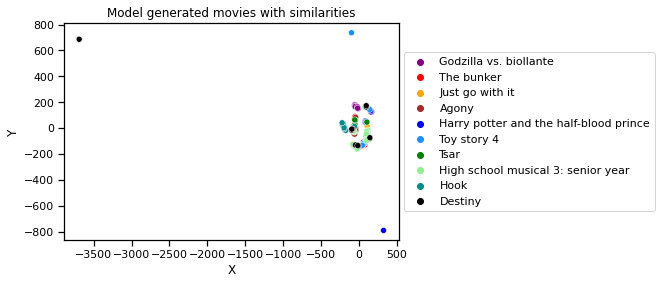

In [30]:
#visialize movies grouped by the query movie_id- for each movie in the test set, generate the sim list and save them in a dict with the query movie as the key
#for each group, plot the query movie and the sim list using distinct color
#generate similarity list for each movie in the test set
vis_group_by_q_movie=[]
for movie_id in test_movies_list:
    sims= model.docvecs.most_similar(movie_id)
    g_movies=[]
    for s in sims:
        g_movies.append(s[0])
    group = {'g_id':movie_id, 'g_movies':g_movies}
    vis_group_by_q_movie.append(group)
#print(vis_group_by_q_movie)    

data_target_list=[]
for group in vis_group_by_q_movie:
    data_target_list = data_target_list + list(itertools.product([group['g_id']], group['g_movies']))
y=[]
data_X = []

#print(data_target_list)

for pair in data_target_list:
    title = helper_fn.find_movie_title_by_id(pair[0],train_data_df)
    y.append(title.values[0].capitalize())
    data_X.append(pair[1])

data_X_vec = [model[tag] for tag in data_X]
tsne=  TSNE(perplexity= 5, n_components=2, init='pca', n_iter=5000, random_state=23)
tsne_obj= tsne.fit_transform(data_X_vec)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':y})

sns.set_context("notebook")
g=sns.scatterplot(x="X", y="Y",
              hue="movie",
              palette=['purple','red','orange','brown','blue',
                       'dodgerblue','green','lightgreen','darkcyan', 'black'],
              legend='full',
              data=tsne_df);
plt.title('Model generated movies with similarities')
g.figure.savefig("generated_simialr_movies.png")

g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)

In [31]:
#further analysis to the results in visualizing the 10 movies and their simialr ones
#get list of genres for each group

all_group_genres_list = []
for group in vis_group_by_q_movie: 
    group_genres_list=[]
    id_genres_list = []
    #genres for the query movie
    movie_genres = helper_fn.find_movie_genre_by_id(group['g_id'], train_data_df)
    id_genres_list = id_genres_list + movie_genres.to_list()[0]
    
    for movie_id in group['g_movies']:
        movie_genres = helper_fn.find_movie_genre_by_id(movie_id, train_data_df)
        group_genres_list = group_genres_list + movie_genres.tolist()[0]
     #   print(group_genres_list[0])
    g_genres={'g_id':group['g_id'], 'q_genres':id_genres_list,'g_genres': list(set(group_genres_list))}
    all_group_genres_list.append(g_genres)
    

group_genres_df = pd.DataFrame(data= {'movie_id':[g['g_id'] for g in all_group_genres_list]
                                      ,'q_genres':[g['q_genres'] for g in all_group_genres_list]
                                      ,'genres_list':[g['g_genres'] for g in all_group_genres_list]})

group_genres_df['q_genres'] = group_genres_df.apply(lambda row: '|'.join(row['q_genres']), axis=1)
group_genres_df['genres_list'] = group_genres_df.apply(lambda row: '|'.join(row['genres_list']), axis=1)
display(tabulate(group_genres_df, headers=['Query Movie', "Query Movie Genres", "Similar movies genres"],tablefmt='html', showindex=False))
group_genres_df.to_excel("models/exp1/sim_gen_list.xlsx", index=False)
#group_genres_df

Query Movie,Query Movie Genres,Similar movies genres
godzilla_vs._biollante,science_fiction_film|kaiju|horror_film,coming-of-age_story|horror_film|action_film|crime_film|fantasy_film|science_fiction_comedy|cyberpunk|post-apocalyptic_film_q1341051|western_film|found_footage_|samurai_cinema|science_fiction_film
the_bunker_(2001_film),mystery_film|horror_film,vampire_films|horror_film|fantasy_film|werewolf_film_q5258881|b_movie|slasher_film|speculative_fiction_film_q2973181|comedy-drama|science_fiction_film
just_go_with_it,romantic_comedy,"lgbt-related_film_q20442589|action_film|war_film|romantic_comedy|fantasy_film|prison_film|film_based_on_literature_q52162262|adventure_film|""childrens_film""|family_film_q1361932|rape_and_revenge_film|comedy-drama|science_fiction_film"
agony_(film),political_drama|biographical_film|historical_film_q17013749,epic_film|cinematic_fairy_tale_q1957385|war_film|art_film|romantic_comedy|biographical_film|historical_film_q17013749|tragicomedy|melodrama|comedy-drama|science_fiction_film
harry_potter_and_the_half-blood_prince_(film),film_based_on_literature_q52162262|fantasy_film,"christmas_film_q28026639|action_film|war_film|romantic_comedy|fantasy_film|musical_film|biographical_film|film_based_on_literature_q52162262|adventure_film|""childrens_film""|costume_drama|parody_film|comedy-drama"
toy_story_4,"""childrens_film""",christmas_film_q28026639|lgbt-related_film_q20442589|neo-noir|action_film|romantic_comedy|fantasy_film|blaxploitation|biographical_film|thriller_film|screwball_comedy|film_based_on_literature_q52162262|female_buddy_film|girls_with_guns|parody_film|comedy-drama|heist_film
tsar_(film),political_drama|historical_film_q17013749,action_film|romance_film|mystery_film|crime_film|biographical_film|erotic_film|thriller_film|film_based_on_literature_q52162262|historical_film_q17013749
high_school_musical_3:_senior_year,"romantic_comedy|musical_film|""childrens_film""|teen_film","christmas_film_q28026639|buddy_film|teen_film|romantic_comedy|action_film|fantasy_film|musical_film|comedy-drama|traditionally_animated_film_q28968511|film_based_on_literature_q52162262|heist_film|""childrens_film""|coming-of-age_story|hood_film"
hook_(film),pirate_film_q2096633|fantasy_film|action_film,comedy_horror|action_film|romance_film|romantic_comedy|teen_film|crime_film|science_fiction_comedy|horror_film|thriller_film|spy_film|slasher_film|parody_film|science_fiction_film
destiny_(1997_film),biographical_film,slice_of_life|lgbt-related_film_q20442589|war_film|romantic_comedy|romance_film|crime_film|fantasy_film|biographical_film|film_based_on_literature_q52162262|spy_film


FileNotFoundError: [Errno 2] No such file or directory: 'models/exp1/sim_gen_list.xlsx'

# Calculate the ranking score for a model

In [52]:
test_data=[
    
    ['harry_potter_and_the_chamber_of_secrets_(film)',
  'harry_potter_and_the_goblet_of_fire_(film)',
  'harry_potter_and_the_half-blood_prince_(film)',
  'harry_potter_and_the_order_of_the_phoenix_(film)',
  'harry_potter_and_the_prisoner_of_azkaban_(film)'],
    ['star_trek:_first_contact',
  'star_trek:_insurrection',
  'star_trek:_nemesis',
  'star_trek_beyond',
  'star_trek_into_darkness'],
    ['godzilla_vs._biollante',
  'godzilla_vs._gigan',
  'godzilla_vs._hedorah',
  'godzilla_vs._king_ghidorah',
  'godzilla_vs._mechagodzilla_ii',
  'godzilla_vs._megaguirus',
  'godzilla_vs._megalon',
  'godzilla_vs._mothra',
  'godzilla_vs._spacegodzilla'],
    [ 'x-men:_apocalypse',
  'x-men:_days_of_future_past',
  'x-men:_the_last_stand',
  'x-men_(film)',
  'x-men_origins:_wolverine']
]
len(test_data)

4

In [50]:
imp.reload(eval_fn)
#prepare test data
#test_titles = []
#test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
#test_titles= ['shrek','star trek','pitch perfect','harry potter','godzilla','paddington','x-men']
#test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)

rank_score_list = eval_fn.calculate_rank_score(model,test_data,3)
group_rank_df = pd.DataFrame(data= {'group_id':[g['group_id'] for g in rank_score_list], 'score':[g['group_score'] for g in rank_score_list]})
group_rank_df.append(group_rank_df.sum(numeric_only=True), ignore_index=True)
group_rank_df.loc['Column_Total']= group_rank_df.sum(numeric_only=True, axis=0)
group_rank_df.iloc[len(group_rank_df)-1].group_id = "Total"
group_rank_df.fillna(" jkj")

display(tabulate(group_rank_df, headers=['Movies Group', "Rank Score"],tablefmt='html', colalign=("right", "left"),showindex=False))

d:\programs\python39\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Movies Group,Rank Score
harry_potter_and_the_prisoner_of_azkaban_(film),25
star_trek_into_darkness,0
godzilla_vs._spacegodzilla,3
x-men_origins:_wolverine,0
nan,28


In [51]:
#Calculate model BLEU score
test_titles = []
test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)

In [53]:
bleu_score = eval_fn.calculate_model_bleu_score(model, test_data, train_data_df, 5)
bleu_score*100

63.47777777777779

In [ ]:
test_titles = []
test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)
test_data

test_titles=[
    
    ['harry_potter_and_the_chamber_of_secrets_(film)',
  'harry_potter_and_the_goblet_of_fire_(film)',
  'harry_potter_and_the_half-blood_prince_(film)',
  'harry_potter_and_the_order_of_the_phoenix_(film)',
  'harry_potter_and_the_prisoner_of_azkaban_(film)'],
    ['star_trek:_first_contact',
  'star_trek:_insurrection',
  'star_trek:_nemesis',
  'star_trek_beyond',
  'star_trek_into_darkness'],
    ['godzilla_vs._biollante',
  'godzilla_vs._gigan',
  'godzilla_vs._hedorah',
  'godzilla_vs._king_ghidorah',
  'godzilla_vs._mechagodzilla_ii',
  'godzilla_vs._megaguirus',
  'godzilla_vs._megalon',
  'godzilla_vs._mothra',
  'godzilla_vs._spacegodzilla'],
    [ 'x-men:_apocalypse',
  'x-men:_days_of_future_past',
  'x-men:_the_last_stand',
  'x-men_(film)',
  'x-men_origins:_wolverine']
]

In [ ]:
len(vis_genres_sample_df)

## visualize movies by genre
#genres_sample_df contains movies from the genres 'Romantic_Comedy','Drama','Adventure','Crime','Action','Unknown'

In [ ]:
y=[]
data_X = []

#print(data_target_list)



vis_genres_sample_df = genres_sample_df.copy()

vis_genres_sample_df['data_X_vec']= vis_genres_sample_df.apply(lambda movie:model[movie.movie_id], axis=1)
vis_genres_sample_df['y']= vis_genres_sample_df.apply(lambda movie: assign_genre(genres_df, movie.movie_id), axis=1)

data_X_vec = list(vis_genres_sample_df['data_X_vec'].values)
y = vis_genres_sample_df['y']
tsne=  TSNE(perplexity= 5, n_components=2, init='pca', n_iter=5000, random_state=23)
tsne_obj= tsne.fit_transform(data_X_vec)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':y})
tsne_df.head()
sns.scatterplot(x="X", y="Y",
              data=tsne_df);

g=sns.scatterplot(x="X", y="Y",
              hue="movie",
         #     palette=['purple','red','orange','brown','blue','black'],
              legend='full',
              data=tsne_df);
plt.title('Movies grouped by genre ')
g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)

## plot sequelmovies with some noise data with labels

In [32]:
def tsne_plot_doc2vec(model, samples,movies_dict,height, width):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    

    for doc in samples:
        tokens.append(model[doc])
        labels.append(movies_dict[doc])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(height, width)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
   # plt.ylim(1, -7)
   # plt.xlim(-7,-1)
    
    
    plt.title('Similar and non-similar movies')
    plt.show()
    #plt.figimage.savefig('movies_labels_large.png',  bbox_inches='tight')
    plt.close() 
    

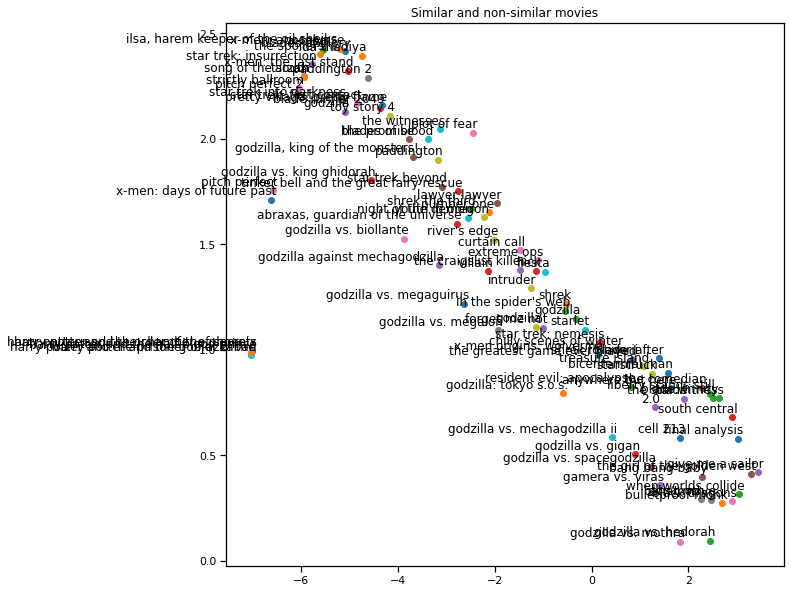

In [33]:
tsne_plot_doc2vec(model, sequel_sampled_data_df.movie_id,movies_dict,10, 10)

## Not sure what is this for

In [ ]:
def tsne_plot_doc2vec_categorized(model, samples,movies_dict, w,h):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    colors = []
    

    for doc in samples:
        tokens.append(model[doc])
        labels.append(movies_dict[doc])
        colors.append(assign_color(genres_df, doc))
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(w, h)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color= colors[i][0] )
        plt.annotate('', #labels[i],
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
   # plt.xlim(-4.0, -1.0)
  #  display(HTML("<b>%d words most similar to '%s'</b>" % (n,word)))
    plt.title('Movies Distribution by Genre')
    plt.legend( labels=['Romantic_Comedy','Drama','Adventure','Crime','Action','Unknown'])
    plt.savefig('movies_genre.png')
   # plt.show(block=False)
    plt.show()
genres_sample_df

In [ ]:
tsne_plot_doc2vec_categorized(model, set(genres_sample_df[0:100].movie_id), movies_dict, 12,12)

In [ ]:
genre_samples= genres_sample_df.movie_id.values.tolist()
len(genre_samples)

In [ ]:
col_data=train_data_df[col_name]
val_list=[]
for data in col_data:
    for val in data:
        val_list.append(val)
occurence_count = Counter(val_list)
high_cnt = occurence_count.most_common(10)[0:10]
x= [cnt[0] for cnt in high_cnt ]


In [ ]:
tsne_plot_doc2vec(model, set(genre_samples[0:100]), movies_dict)

In [ ]:
from seaborn import sns

In [35]:
#Plot movies by features

def plot_movies_by_feature(col_name, train_data_df, sample_size):
    col_data=train_data_df[col_name]
    val_list=[]
    for data in col_data:
        for val in data:
            val_list.append(val)

    occurence_count = Counter(val_list)
    print(len(occurence_count))
    high_cnt = occurence_count.most_common(sample_size)[0:sample_size]
    val_list= [cnt[0] for cnt in high_cnt ]
    print(val_list)
    
    movies_val_dict={}

    #val_list = random.sample(val_list,sample_size)
    for val in val_list:
        movies_val_dict[val] = helper_fn.find_movies_by_col_value(col_name, val, train_data_df)    
    
    data_target_list=[]
    for key in val_list:
        for val in movies_val_dict[key]:
            data_target_list.append((key,val))
    y=[]
    data_X = []

    for pair in data_target_list:
        y.append(pair[0])
        data_X.append(pair[1])

    data_X_vec = [model[tag] for tag in data_X]
    sns.set_context('notebook')
    tsne=  TSNE(perplexity= 50, n_components=2, init='pca', n_iter=5000, random_state=23)
    tsne_obj= tsne.fit_transform(data_X_vec)
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        col_name:y})
    return tsne_df

def draw_plot(tsne_df, col_name, title,filename):
   # sns.set_palette(sns.color_palette("default", 20))
    #sns.color_palette()
    tsne_df[col_name] = tsne_df[col_name].apply(lambda c: c[1:] if c.startswith('_') else c)
    g=sns.scatterplot(x="X", y="Y",
                  hue=col_name,
              #    hue_order= cat_order,
                #  palette=['purple','red','orange'],
                  legend= 'full',            
                  data=tsne_df);
    
    g.set_title(title)
    #g.set_xlim(-600, 800)
    #g.set_ylim(-800, 600)
    g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)
    g.figure.savefig(filename)
    plt.close
    
        
    

In [54]:
sample_size= 5
#col_name= 'actor_name' #10 actors
#col_name='writer_name' #10 samples
#col_name='director_name' #10
#col_name='country' #10 samples
col_name='genre' #top 10

plot_df = plot_movies_by_feature(col_name,train_data_df, sample_size)
title= "Movies grouped by "+col_name
filename= col_name+"_plot.png"

241
['action_film', 'crime_film', 'horror_film', 'romantic_comedy', 'romance_film']


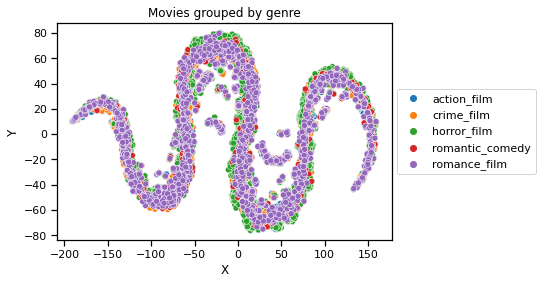

In [55]:
draw_plot(plot_df,col_name, title, filename)

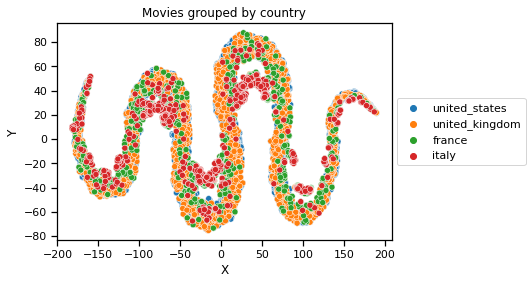

In [ ]:
len(plot_df)

In [ ]:
def show_closest_line(similar_movies, query_movie, n):
   # display(html.HTML("<b>%d words most similar to '%s'</b>" % (n, query_movie)))
    
    tops = similar_movies
    
    items = [item[0] for item in tops]
    sims = [item[1] for i,item in enumerate(tops)]
    
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)

    
    plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Rank')
    plt.ylabel('Similarity')
    plt.xlim(-1,n)

    
    ax.plot(sims, color="purple", alpha=0.5)
    
    for item, x, y in zip(items, range(n), sims):
        ax.annotate( item, xy=(x, y), xytext=(20, -7), textcoords='offset points', 
                     ha='right', va='bottom', color='orange', fontsize=14 )

    
    
    
    plt.show()

In [ ]:
#query each movie for most similar list
#save each query movie and the result in a dictionary
#for each group, retrieve actors for all the movies in the list

group_by_q_movie=[]
all_groups_actors=[]
for movie_id in test_movies_list:
    sims= model.docvecs.most_similar(movie_id,topn=5)
    g_movies=[]
    for s in sims:
        g_movies.append(s[0])
    group = {'g_id':movie_id, 'g_movies':g_movies}
    group_by_q_movie.append(group)
    
    
for group in group_by_q_movie:
    query_movie_id = group['g_id']
    sim_movies_id_list = group['g_movies']
    group_actors=[]
    group_movies=[]
    actors = helper_fn.find_actors_by_movie_id(query_movie_id, train_data_df)
    
    group_actors = group_actors + actors[0]
    #print(group_actors)
    group_movies.append(query_movie_id)    
   # print("group ID {}".format(query_movie_id))
    
    for movie_id in sim_movies_id_list:
        #print("sim movie id {} :".format(movie_id))
        actors = helper_fn.find_actors_by_movie_id(movie_id, train_data_df)
        group_actors = group_actors + actors[0]
        group_movies.append(movie_id)
        #print(group_actors)
    all_groups_actors.append({'g_id':query_movie_id, 'g_movies':group_movies, 'g_actors':group_actors})


group_actors_df = pd.DataFrame(data= {'movie_id':[g['g_id'] for g in all_groups_actors], 
                'movies_list':[g['g_movies'] for g in all_groups_actors],
               'actors_list':[g['g_actors'] for g in all_groups_actors]
               })


#display(group_actors_df)

data_target_list=[]
movies_target_list=[]
actors_target_list=[]

for group in all_groups_actors:
    movies_target_list = movies_target_list + list(itertools.product([group['g_id']], group['g_movies']))
print(len(movies_target_list))
x_movies_df= pd.DataFrame(data= list(set(movies_target_list)), columns=['Y','X'])
x_movies_df['type']= 'movie'

    
for group in all_groups_actors:
    actors_target_list = actors_target_list + list(itertools.product([group['g_id']], group['g_actors']))
print(len(actors_target_list))
x_actors_df= pd.DataFrame(data= list(set(actors_target_list)), columns=['Y','X'])
x_actors_df['type']= 'actor'

final_df = x_actors_df.append(x_movies_df)

In [ ]:
###Visualization
print(len(final_df))

final_df.reset_index(drop=True, inplace= True)
y=[]
data_X = []
type_x =[]
final_df['title']= final_df.apply(lambda row: helper_fn.find_movie_title_by_id(row.Y,train_data_df).values[0], axis=1)
final_df['title'] = final_df['title'].str.capitalize()
#y_vec = [model[tag] for tag in y]

doctags= model.docvecs.doctags
vocab = model.wv.vocab
final_df = final_df.sample(frac=1)
plt.rcParams["figure.figsize"] = [8,6]
data_X_vec=[]
for tag in final_df['X'].values :                
    if tag in doctags:
        tag_vec= model[tag] 
    else:
        if tag in vocab:
            tag_vec= model.wv[tag] 
        else:
            tag_vec=[0]*50
    data_X_vec.append(tag_vec)
final_df['X_vec']=data_X_vec

tsne=  TSNE(perplexity= 50, n_components=2, init='pca', n_iter=7000, random_state=23)

tsne_obj= tsne.fit_transform(final_df.X_vec.to_list())

tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':final_df.title.to_list(),
                         'X_type':final_df.type.to_list()})

#sns.set(rc={'figure.figsize':(11.7,8.27)})


#movies_only=tsne_df[tsne_df['X_type']=='actor']

In [ ]:
sns.set_context('paper')
palette=['purple','red','orange','brown','blue','dodgerblue','green','lightgreen','darkcyan', 'black']
g = sns.scatterplot(x="X", y="Y", data=tsne_df, palette= palette, hue="movie");

tsne_df.apply(lambda point: g.scatter(point['X'], point['Y'], marker=find_marker(point['X_type'])), axis=1)

              



g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)


In [ ]:
def find_marker(type_X):
    if type_X == 'movie':
        return "o"
    else:
        if type_X == 'actor':
            return "s"